## Build, Train & Score Model with PyTorch

### Introduction: Rahul Nair


## Import Dependencies

In [1]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")


/home/unrahul/anaconda3/envs/pytorch_bench/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Print Software Versions

In [2]:
print(f"torch version: {torch.__version__}")
print(f"ipex version: {ipex.__version__}")


torch version: 1.12.1
ipex version: 1.12.100


## Define Utility Functions

### seed_everything and set_env_vars

In [3]:
def seed_everything(seed: int = 4242):
    """set all random seeds using `seed`"""
    print(f"seed set to: {seed}")
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def set_env_vars() -> int:
    """set openMP and torch params"""
    num_physical_cores = psutil.cpu_count(logical=False)
    print(f"setting omp num threads: {num_physical_cores}")
    os.environ["OMP_NUM_THREADS"] = str(num_physical_cores)
    os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
    os.environ["KMP_BLOCKTIME"] = "1"
    return num_physical_cores


seed_everything(9342)
num_physical_cores = set_env_vars()


seed set to: 9342
setting omp num threads: 16


## Define dataset transforms for training and validation sets

In [4]:
# training, validation  dataset transforms
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomApply(
                [transforms.GaussianBlur(kernel_size=(1, 3), sigma=(1, 3))], p=0.2
            ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(180),
            transforms.ToTensor(),
            transforms.Normalize(*imagenet_stats),
        ]
    ),
    "valid": transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    ),
}


## Create dataset for Training and Validation

In [5]:
# create dataset for Training and Validation
num_physical_cores = psutil.cpu_count(logical=False)
data_dir = pathlib.Path("./data/ThreeClassManualRemove0s/")
TRAIN_DIR = data_dir / "train"
VALID_DIR = data_dir / "val"

# no image transforms for validation data
#orig_train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["valid"])
train_data = datasets.ImageFolder(TRAIN_DIR, transform=img_transforms["train"])
#train_data = torch.utils.data.ConcatDataset([orig_train_data, train_data])
valid_data = datasets.ImageFolder(VALID_DIR, transform=img_transforms["valid"])


## Define Utility Functions to visualize class distributions

### data_distribution and plot_data_distribution

In [6]:
def data_distribution(dataset=train_data, path: str = TRAIN_DIR) -> dict:
    """return dict of data distribtion of each class."""
    cls_count = dict.fromkeys(dataset.class_to_idx, 0)
    for cls in cls_count.keys():
        cls_count[cls] = len(fnmatch.filter(os.listdir(f"{path}/{cls}"), "*.png"))
    return cls_count


def plot_data_distribution(data_dist: dict, title: str = ""):
    """plot data distribution"""
    cls, count = list(data_dist.keys()), list(data_dist.values())
    p = sns.barplot(x=cls, y=count)
    p.set_title(title)


# Plot Data Distributions

train data dist: {'0': 1006, '1': 987, '2': 1356}


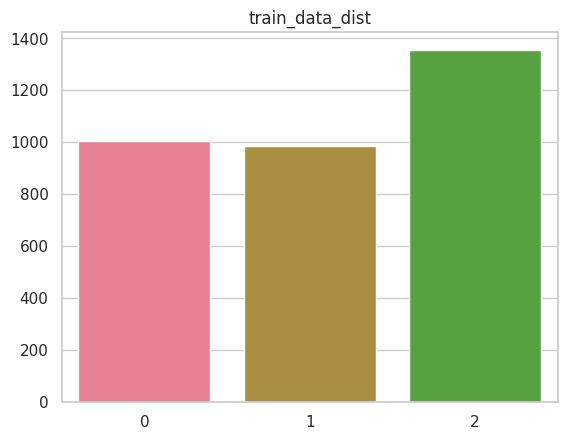

In [7]:
train_data_dist = data_distribution(train_data, path=TRAIN_DIR)
plot_data_distribution(train_data_dist, "train_data_dist")
print(f"train data dist: {train_data_dist}")


valid data dist: {'0': 239, '1': 231, '2': 341}


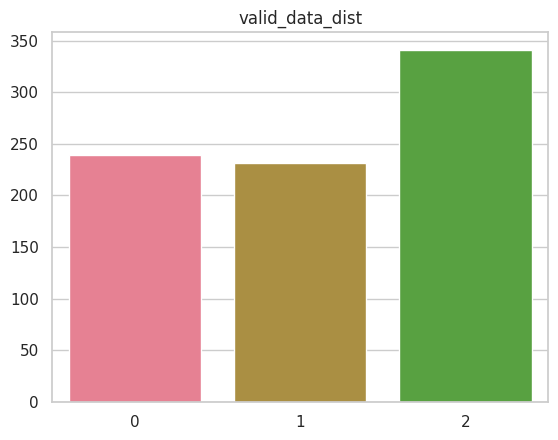

In [8]:
valid_data_dist = data_distribution(valid_data, path=VALID_DIR)
plot_data_distribution(valid_data_dist, "valid_data_dist")
print(f"valid data dist: {valid_data_dist}")


In [52]:
# create data loaders
batch_size = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
print(f"batch size: {batch_size}")


batch size: 10


## Define Utility Functions to display data from dataloader



In [53]:
def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean


def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=2, figsize=(10, 6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    #plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))


## Display Sample Data

training data


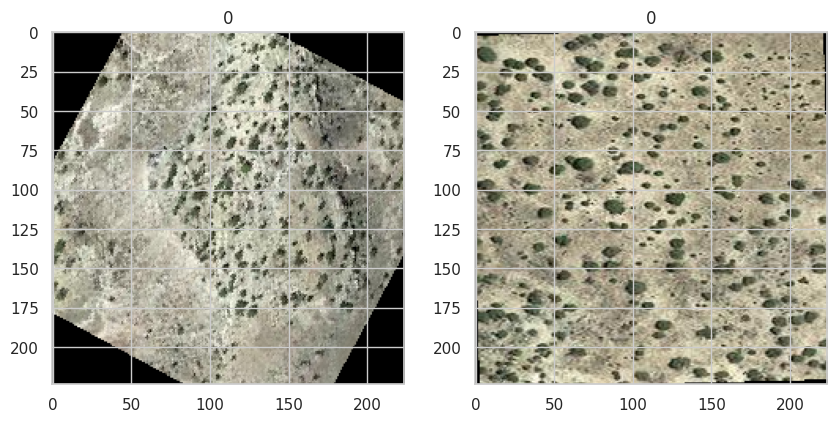

In [54]:
print("training data")
show_data(train_dataloader)


validation data


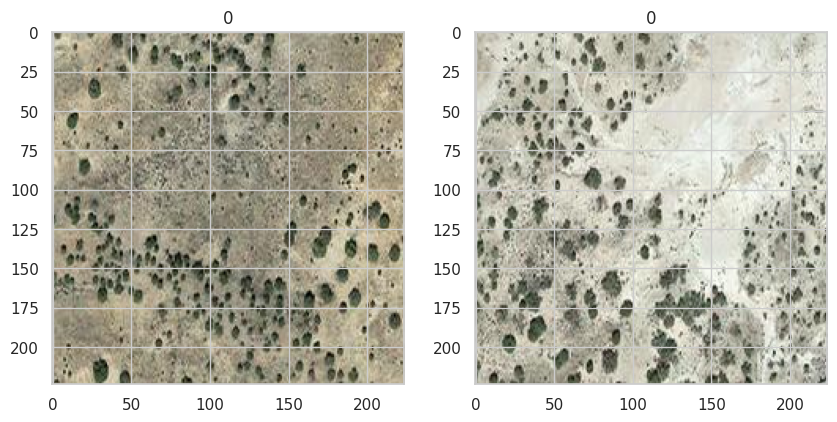

In [55]:
print("validation data")
show_data(valid_dataloader)


## Define the Model Class
    Our model is a Resnet18 based 3 class classification Deep Neural Network

### AKA DinosaurBoneFinder Class

In [56]:
class DinosourBoneFinder(nn.Module):
    """
    A model to classify aerial images that could potentially have Jurassic fossils.
    We are using a pretrained resnet backbone model
    and images given to model are classified into one of 3 classes.
    0 - no bone
    1 - bone possible
    2 - bone likely


    We currently use the resnet18 model as a backbone
    """

    def __init__(self, backbone=18, simple=False):
        super(DinosourBoneFinder, self).__init__()
        backbones = {
            18: models.resnet18,
            34: models.resnet34,
            50: models.resnet50,
            101: models.resnet101,
        }
        self.network = backbones[backbone](pretrained=True)
        for m, p in zip(self.network.modules(), self.network.parameters()):
            if isinstance(m, nn.BatchNorm2d):
                p.requires_grad = False
        if simple:
            self.network.fc = nn.Linear(self.network.fc.in_features, 3)
        else:
            self.network.fc = nn.Sequential(
                nn.Linear(self.network.fc.in_features, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(
                    256, 3
                ),  # here we are using 3 for `out_features` as the image given
                # to the model can be one of 3 classes (0 - no bone, 1 - bone possible, 2 - bone likely)
            )

    def forward(self, x_batch):
        return self.network(x_batch)


## Define Metrics - Utility class to measure accuracy of the model and plot metrics

In [57]:
class Metrics:
    """class that holds logic for calculating accuracy and printing it"""

    def __init__(self):
        self.acc = {"train": [], "val": []}
        self.loss = {"train": [], "val": []}

    @staticmethod
    @torch.no_grad()
    def accuracy(yhat, labels, debug):
        """accuracy of a batch"""
        yhat = torch.log_softmax(yhat, dim=1)  # softmax of logit output
        yhat = yhat.max(1)[1]# get index of max values
        if debug:
            #print(f"outputs: {yhat} labels: {labels}")
            print(f" output == label ?: {torch.equal(yhat, labels)}")
        acc = yhat.eq(labels).sum() / len(yhat)
        return acc

    def __str__(self):
        return (
            f"loss:\n training set  : {self.loss['train'][-1]:.4}\n validation set: {self.loss['val'][-1]:.4}\n"
            f"accuracy:\n training set  : {self.acc['train'][-1]:.4}\n validation set: {self.acc['val'][-1]:.4} "
        )

    def plot(self):
        """plot loss and acc curves"""
        train_acc = [x * 100 for x in self.acc["train"]]
        val_acc = [x * 100 for x in self.acc["val"]]
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 2.5))
        ax[0].plot(self.loss["train"], "-o")
        ax[0].plot(self.loss["val"], "-o")
        ax[0].set_ylabel("loss")
        ax[0].set_title(f"Train vs validation loss")
        ax[1].plot(train_acc, "-o")
        ax[1].plot(val_acc, "-o")
        ax[1].set_ylabel("accuracy (%)")
        ax[1].set_title("Training vs validation acc")
        for x in ax:
            x.yaxis.grid(True)
            x.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            x.legend(["train", "validation"])
            x.set_xlabel("epoch")
        plt.show()


# Define Trainer Class

In [58]:
class Trainer:
    """Trainer class that takes care of training and validation passes."""

    def __init__(
        self,
        model,
        device="cpu",
        optimizer=torch.optim.SGD,
        epochs=10,
        lr=0.05,
        ipx=False,
    ):
        self.device = device
        self.model = model.to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.ipx = ipx
        self.epochs = epochs
        self.metrics = Metrics()
        self.lr = lr
        if isinstance(optimizer, torch.optim.Adam):
            self.lr = 2e-3
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

    def forward_pass(self, inputs, labels, debug=True):
        """Perform forward pass of models with `inputs`,
        calculate loss and accuracy and return it.
        """
        outputs = self.model(inputs)  # forward pass model
        loss = self.loss_fn(outputs, labels)  # calculate loss
        acc = self.metrics.accuracy(outputs, labels, debug=debug)
        return loss, acc

    def train_one_batch(self, train_dataloader, max_epoch=100):
        """Train the model using just one batch for max_epoch.
        use this function to debug the training loop"""
        self.model.train()
        self.train_dataloader = train_dataloader
        inputs, labels = next(iter(self.train_dataloader))
        for epoch in range(max_epoch):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels, debug=True)
            loss.backward()  # calculate gradients
            self.optimizer.step()  # update params
            print(
                f"[Epoch: {epoch+1}]\
                    \n loss: {loss.item()/len(self.train_dataloader):.4f}\
                     \n acc: {acc.item()/len(self.train_dataloader):.4f}"
            )

    def train(self):
        """Training loop, return epoch loss and accuracy."""
        self.model.train()
        t_epoch_loss, t_epoch_acc = 0.0, 0.0
        for inputs, labels in self.train_dataloader:
        #for inputs, labels in tqdm(train_dataloader, desc="tr loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            if self.ipx:
                inputs = inputs.to(memory_format=torch.channels_last)
            self.optimizer.zero_grad()  # zero gradients
            loss, acc = self.forward_pass(inputs, labels)  # forward pass
            loss.backward()  # backward
            self.optimizer.step()  # update gradients
            t_epoch_loss += loss.item()
            t_epoch_acc += acc.item()
        return (t_epoch_loss, t_epoch_acc)

    @torch.no_grad()
    def validate(self):
        """Validation loop, return validation epoch loss and accuracy."""
        self.model.eval()
        v_epoch_loss, v_epoch_acc = 0.0, 0.0
        for inputs, labels in tqdm(self.valid_dataloader, desc="ev loop"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            loss, acc = self.forward_pass(inputs, labels)
            v_epoch_loss += loss.item()
            v_epoch_acc += acc.item()
        return (v_epoch_loss, v_epoch_acc)

    def _to_ipx(self):
        """convert model memory format to channels_last to IPEX format."""
        self.model.train()
        self.model = self.model.to(memory_format=torch.channels_last)
        self.model, self.optimizer = ipex.optimize(
            self.model, optimizer=self.optimizer, dtype=torch.float32
        )

    def fine_tune(self, train_dataloader, valid_dataloader, debug=False):
        """Fine tune `self.model` using training set and measure perf using
        training and validation set.

        `debug`: if True, will run train_one_batch function with one batch
        of train_dataloader to see if we can overfit the model, used to debug
        the training loop.

        `train_dataloader`: training set
        `valid_dataloader`: validation set
        """
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        if debug:
            self.train_one_batch()
        else:
            time_per_epoch = []
            if self.ipx:
                self._to_ipx()
            print(f"fine tuning model for max epochs: {self.epochs}")
            for epoch in range(self.epochs):
                print(f"Epoch: [{epoch+1}]")
                st_time = time.perf_counter()
                t_epoch_loss, t_epoch_acc = self.train()
                fn_time = time.perf_counter()
                time_per_epoch.append(fn_time - st_time)
                v_epoch_loss, v_epoch_acc = self.validate()
                self.metrics.loss["train"].append(t_epoch_loss / len(train_dataloader))
                self.metrics.loss["val"].append(v_epoch_loss / len(valid_dataloader))
                self.metrics.acc["train"].append(t_epoch_acc / len(train_dataloader))
                self.metrics.acc["val"].append(v_epoch_acc / len(valid_dataloader))
                print(self.metrics)
            return time_per_epoch


## Train model

In [59]:
torch.set_num_threads(8)
#torch.set_num_interop_threads(2)
print(torch.get_num_interop_threads())
print(torch.get_num_threads())
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
#os.environ["KMP_BLOCKTIME"] = "0"
model = DinosourBoneFinder()  # init model
trainer = Trainer(model, epochs=100, ipx=True)  # set up trainer with the model
tft = trainer.fine_tune(train_dataloader, valid_dataloader)
#tft = trainer.train_one_batch(train_dataloader)

12
8
fine tuning model for max epochs: 100
Epoch: [1]
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.69it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.65it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.42it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.34it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 13.64it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.84it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.99it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.31it/s]

 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.85it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 13.94it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.05it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.30it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.77it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.96it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 11.63it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.37it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.91it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.35it/s]

 output == label ?: False
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.20it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.42it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.59it/s]

 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.90it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.05it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.32it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.37it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.38it/s]

 output == label ?: False
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.48it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.50it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.44it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.52it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.52it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 14.54it/s]

 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.89it/s]

 output == label ?: True
loss:
 training set  : 0.4826
 validation set: 0.2225
accuracy:
 training set  : 0.8062
 validation set: 0.8878 
Epoch: [2]


 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: Fal

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.06it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.41it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.88it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.96it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.34it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.35it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.27it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.32it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.47it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.54it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.40it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False
loss:
 training set  : 0.364
 validation set: 6.334
accuracy:
 training set  : 0.8716
 validation set: 0.5732 
Epoch: [3]
 output == label ?: False


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.43it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.78it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.13it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.89it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.75it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.38it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.12it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.23it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.30it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.25it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.44it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.50it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.91it/s]

 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 11.70it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.3716
 validation set: 0.1634
accuracy:
 training set  : 0.8773
 validation set: 0.9366 
Epoch: [4]
 output == label ?: False


 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.47it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.64it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.63it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.63it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.05it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.33it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.52it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.53it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.58it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.59it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.21it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.32it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.48it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.40it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.54it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.37it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.3343
 validation set: 0.2583
accuracy:
 training set  : 0.8925
 validation set: 0.889 
Epoch: [5]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 13.28it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.30it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.39it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.37it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.40it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.52it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.52it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.50it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.34it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.47it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.48it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.2387
 validation set: 0.2447
accuracy:
 training set  : 0.9225
 validation set: 0.9 
Epoch: [6]


 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 o

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.58it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.26it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.02it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.17it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.30it/s]

 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.32it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.36it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.46it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.41it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.38it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.34it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.44it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.71it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.02it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.02it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.07it/s]

 output == label ?: False
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.14it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.27it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.33it/s]

 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.42it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.44it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.37it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.44it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.50it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.48it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.36it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.44it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.48it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.49it/s]

 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.17it/s]

 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.2301
 validation set: 0.1345
accuracy:
 training set  : 0.9274
 validation set: 0.95 
Epoch: [7]


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.68it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.64it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.68it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.92it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.29it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.36it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.95it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.05it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.45it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.42it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.74it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.92it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.37it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.2231
 validation set: 0.1759
accuracy:
 training set  : 0.9313
 validation set: 0.9256 
Epoch: [8]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.66it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.63it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.26it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.32it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.47it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.80it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.40it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.47it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.61it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.51it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1643
 validation set: 0.06778
accuracy:
 training set  : 0.9406
 validation set: 0.9732 
Epoch: [9]


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 outpu

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.73it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.68it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.58it/s]

 output == label ?: True
 output == label ?: False


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.52it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.56it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.50it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.44it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.36it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.34it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.28it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.27it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.30it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.14it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.40it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:02, 12.81it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.33it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.67it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.08it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.43it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 13.78it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.98it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.20it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.88it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.14it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1716
 validation set: 0.0547
accuracy:
 training set  : 0.9424
 validation set: 0.978 
Epoch: [10]
 output == label ?: False


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output ==

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.71it/s]

 output == label ?: False
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.75it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.53it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.54it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.54it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.16it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.30it/s]

 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.36it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.41it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.49it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.47it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.39it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.36it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.36it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.67it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.25it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.42it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.51it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.33it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.09it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.99it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.23it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.10it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.86it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.06it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1781
 validation set: 0.1564
accuracy:
 training set  : 0.9461
 validation set: 0.9512 
Epoch: [11]
 output == label ?: True


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == l

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.74it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.25it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.16it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.32it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.87it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.12it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.23it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.61it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.86it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.01it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.85it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.18it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.27it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.27it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.24it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.34it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.35it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.40it/s]

 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.47it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.50it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.51it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.54it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.40it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.43it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.38it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.45it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.23it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.60it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1647
 validation set: 0.08356
accuracy:
 training set  : 0.9487
 validation set: 0.9756 
Epoch: [12]
 output == label ?: True


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.70it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.61it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.42it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 13.76it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.03it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.18it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.39it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.13it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.25it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.30it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.34it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.37it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.39it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.21it/s]

 output == label ?: False
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.33it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.35it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.82it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.06it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.20it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.34it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.31it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.36it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.41it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.47it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.46it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.41it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.1601
 validation set: 0.1024
accuracy:
 training set  : 0.9519
 validation set: 0.9476 
Epoch: [13]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output ==

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.67it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.71it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.66it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.61it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.60it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.63it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.61it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.49it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.45it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.45it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.54it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.35it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.35it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.36it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.33it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.33it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.19it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.33it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.43it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.45it/s]

 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.06it/s]

 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.37it/s]

 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.69it/s]

 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 12.64it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.01it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.45it/s]

 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.97it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.86it/s]

 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.25it/s]

 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.08it/s]

 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1366
 validation set: 0.05354
accuracy:
 training set  : 0.9594
 validation set: 0.9817 
Epoch: [14]
 output == label ?: True


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output ==

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.60it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.42it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.79it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.89it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.23it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.66it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.79it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.00it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: False


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.25it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.08it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.10it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.23it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.87it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.01it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.91it/s]

 output == label ?: True
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.13it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.30it/s]

 output == label ?: True
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.40it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.65it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.98it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.00it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.89it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.06it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.10it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 12.59it/s]

 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.93it/s]

 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.1384
 validation set: 0.09733
accuracy:
 training set  : 0.9552
 validation set: 0.9646 
Epoch: [15]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.68it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.63it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.55it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.04it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.26it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.48it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.51it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.62it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.57it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.61it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.56it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:04<00:00, 14.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.60it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.51it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.52it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
loss:
 training set  : 0.1443
 validation set: 0.3515
accuracy:
 training set  : 0.9516
 validation set: 0.9122 
Epoch: [16]


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output ==

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.66it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.65it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.48it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.02it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.56it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.59it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.56it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1278
 validation set: 0.06975
accuracy:
 training set  : 0.9603
 validation set: 0.9744 
Epoch: [17]


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.60it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.51it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.07it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.19it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.18it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.27it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.23it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.25it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.26it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.33it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.64it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.86it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.64it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.05it/s]

 output == label ?: True
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.18it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.42it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.49it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.32it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.03it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.20it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.22it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.07it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.22it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.29it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1202
 validation set: 0.04586
accuracy:
 training set  : 0.9597
 validation set: 0.9854 
Epoch: [18]
 output == label ?: True


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == l

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.67it/s]

 output == label ?: False
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:06, 12.97it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.66it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.99it/s]

 output == label ?: False
 output == label ?: False


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.21it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.32it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.11it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.25it/s]

 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.29it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.34it/s]

 output == label ?: False
 output == label ?: False


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.28it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.31it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.24it/s]

 output == label ?: False
 output == label ?: False


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.01it/s]

 output == label ?: False


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.09it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.14it/s]

 output == label ?: False
 output == label ?: False


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.17it/s]

 output == label ?: False


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.57it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.71it/s]

 output == label ?: False
 output == label ?: False


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.87it/s]

 output == label ?: False


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.98it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.08it/s]

 output == label ?: False
 output == label ?: False


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.97it/s]

 output == label ?: False


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.07it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.00it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.69it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.92it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.33it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.43it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.49it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.52it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.55it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1136
 validation set: 1.981
accuracy:
 training set  : 0.9632
 validation set: 0.6268 
Epoch: [19]
 output == label ?: False


 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 out

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.72it/s]

 output == label ?: False
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.68it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.58it/s]

 output == label ?: False
 output == label ?: False


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.91it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.17it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.39it/s]

 output == label ?: False
 output == label ?: False


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.77it/s]

 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.00it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.16it/s]

 output == label ?: True
 output == label ?: False


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.29it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.32it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.28it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.27it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.17it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.50it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.80it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.03it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.15it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.29it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.39it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.03it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.37it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.37it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.2012
 validation set: 0.1538
accuracy:
 training set  : 0.9376
 validation set: 0.9549 
Epoch: [20]
 output == label ?: False


 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == l

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.14it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.52it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.00it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.33it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.38it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.46it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.13it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.44it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.03it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.17it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.51it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.83it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.19it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False
loss:
 training set  : 0.1336
 validation set: 0.5047
accuracy:
 training set  : 0.9555
 validation set: 0.8317 
Epoch: [21]
 output == label ?: False


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.00it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.44it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 13.98it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.17it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.30it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.39it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.50it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 13.02it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.86it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.67it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.61it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.83it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.64it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.86it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.06it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.15it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.26it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.88it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.06it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.23it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.86it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.22it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.33it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.39it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.03it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1352
 validation set: 0.04643
accuracy:
 training set  : 0.9582
 validation set: 0.9841 
Epoch: [22]
 output == label ?: True


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.13it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.23it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.94it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.24it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.35it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.37it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1401
 validation set: 0.04999
accuracy:
 training set  : 0.9555
 validation set: 0.9915 
Epoch: [23]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.36it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.56it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.36it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.79it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.77it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.00it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.01it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.30it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.29it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.26it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.25it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.03it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.18it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.30it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.36it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.40it/s]

 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.46it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.83it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.04it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.24it/s]

 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.51it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.51it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1022
 validation set: 0.04556
accuracy:
 training set  : 0.969
 validation set: 0.9854 
Epoch: [24]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.69it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.67it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.59it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.60it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.53it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.42it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.15it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.04it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.18it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.24it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.25it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.26it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.34it/s]

 output == label ?: False
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.40it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.01it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.46it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.43it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.74it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.95it/s]

 output == label ?: False
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.13it/s]

 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.33it/s]

 output == label ?: True
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.39it/s]

 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.29it/s]

 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.95it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.27it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.08954
 validation set: 0.1578
accuracy:
 training set  : 0.9687
 validation set: 0.9366 
Epoch: [25]
 output == label ?: True


 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == labe

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.60it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.08it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.81it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.08it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.09313
 validation set: 0.08745
accuracy:
 training set  : 0.9693
 validation set: 0.9866 
Epoch: [26]


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.65it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.94it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.37it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.68it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.93it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.51it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1045
 validation set: 0.03684
accuracy:
 training set  : 0.9654
 validation set: 0.989 
Epoch: [27]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == labe

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.76it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.99it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.25it/s]

 output == label ?: False


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.31it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.72it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.89it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.34it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.68it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.94it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.83it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.09it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.22it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.02it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.16it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.10it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.23it/s]

 output == label ?: False
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.32it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.39it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.39it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.36it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.38it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.40it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.42it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.42it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.18it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.13it/s]

 output == label ?: True
loss:
 training set  : 0.08802
 validation set: 0.08974
accuracy:
 training set  : 0.974
 validation set: 0.9695 
Epoch: [28]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?:

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.56it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.66it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.82it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.52it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.55it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.83it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.18it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.21it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:04, 10.90it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:04, 10.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 11.29it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 11.71it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.42it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.38it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.68it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.92it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.02it/s]

 output == label ?: False
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.15it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.66it/s]

 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.96it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 13.38it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.71it/s]

 output == label ?: True
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.51it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.01it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.16it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.41it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.09746
 validation set: 0.05414
accuracy:
 training set  : 0.9749
 validation set: 0.978 
Epoch: [29]


 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == lab

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.80it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.05it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.49it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.36it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.71it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.94it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.35it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.08it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.77it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.17it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.45it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.48it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.52it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.24it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.1023
 validation set: 0.08638
accuracy:
 training set  : 0.9669
 validation set: 0.9695 
Epoch: [30]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == lab

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.51it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.07it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.41it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.47it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.48it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.53it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 13.57it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.94it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.04it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.10it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.15it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.79it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.91it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.49it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.78it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.52it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.58it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.81it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.02it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.90it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.12it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.38it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.73it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.99it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.10it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.08372
 validation set: 0.03187
accuracy:
 training set  : 0.9734
 validation set: 0.9927 
Epoch: [31]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.66it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.98it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.26it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.29it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.30it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.13it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.54it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.07314
 validation set: 0.0588
accuracy:
 training set  : 0.9752
 validation set: 0.9817 
Epoch: [32]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 13.95it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.22it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.36it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.43it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.29it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.69it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.27it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.33it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.58it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.86it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.09it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.90it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.00it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.20it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.31it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.27it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.37it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.44it/s]

 output == label ?: False
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.39it/s]

 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.22it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.06it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.21it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.37it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.40it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.08705
 validation set: 0.06184
accuracy:
 training set  : 0.9725
 validation set: 0.9841 
Epoch: [33]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.57it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:03, 14.59it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.15it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 13.97it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.37it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.05it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.06796
 validation set: 0.06199
accuracy:
 training set  : 0.98
 validation set: 0.9829 
Epoch: [34]


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.68it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.65it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.93it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.73it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.77it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.05it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.10it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.70it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.58it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.67it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.71it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.90it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.04it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.17it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.07it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.29it/s]

 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.32it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.41it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.44it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.41it/s]

 output == label ?: False
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.44it/s]

 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.42it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.14it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.23it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.25it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False
loss:
 training set  : 0.09937
 validation set: 0.1032
accuracy:
 training set  : 0.9707
 validation set: 0.9634 
Epoch: [35]
 output == label ?: False


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.41it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.34it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.77it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.01it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.30it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.37it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.55it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.43it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.47it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.50it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.07it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.08477
 validation set: 0.1573
accuracy:
 training set  : 0.9734
 validation set: 0.9415 
Epoch: [36]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == labe

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:04, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 14.12it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 14.21it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 13.72it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:01<00:03, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:02<00:03, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:02<00:03, 13.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.96it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:03<00:02, 14.15it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:04<00:00, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.01it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.06918
 validation set: 0.04071
accuracy:
 training set  : 0.98
 validation set: 0.989 
Epoch: [37]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.60it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.61it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.32it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 11.87it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.65it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.34it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.64it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.76it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.86it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.96it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.93it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.03it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.27it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.89it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.07it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.25it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.33it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.21it/s]

 output == label ?: True
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.28it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.31it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.33it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.41it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.07123
 validation set: 0.02982
accuracy:
 training set  : 0.9773
 validation set: 0.9915 
Epoch: [38]
 output == label ?: True


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.60it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.15it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.61it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.50it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.08585
 validation set: 0.02357
accuracy:
 training set  : 0.9758
 validation set: 0.9939 
Epoch: [39]


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.35it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.32it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 11.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.81it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.08471
 validation set: 0.02156
accuracy:
 training set  : 0.9797
 validation set: 0.9939 
Epoch: [40]


 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.59it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.56it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.42it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.44it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.47it/s]

 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.00it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.06it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.31it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.60it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 12.79it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.50it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.62it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.07082
 validation set: 0.05426
accuracy:
 training set  : 0.9782
 validation set: 0.9841 
Epoch: [41]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.25it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.91it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 11.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.15it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.42it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.03it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05348
 validation set: 0.02742
accuracy:
 training set  : 0.9857
 validation set: 0.989 
Epoch: [42]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: Tr

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 13.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:06, 12.53it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.78it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.02it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.59it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.19it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.76it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.91it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.24it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.69it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.86it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.01it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.08it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.16it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.33it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.75it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.03it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.76it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.21it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.56it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 12.51it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.04it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.60it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.60it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05319
 validation set: 0.025
accuracy:
 training set  : 0.9851
 validation set: 0.9927 
Epoch: [43]
 output == label ?: False


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: F

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.54it/s]

 output == label ?: True
 output == label ?: False


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.56it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.09it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.24it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.33it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.36it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.24it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.60it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.89it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.96it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 13.35it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.48it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.36it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.56it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.45it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.13it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.78it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.83it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.58it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.82it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 14.00it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.15it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.25it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.06759
 validation set: 0.02216
accuracy:
 training set  : 0.9779
 validation set: 0.9939 
Epoch: [44]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.55it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.24it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.37it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.05it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.21it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.56it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 12.65it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.01it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.61it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.58it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.96it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.98it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.23it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.32it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.67it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.18it/s]

 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.25it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.90it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.38it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.82it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.09735
 validation set: 0.04923
accuracy:
 training set  : 0.9719
 validation set: 0.9915 
Epoch: [45]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.47it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.35it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.35it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:04, 14.44it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.24it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.58it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.81it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.06it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.14it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.06it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.00it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.79it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.93it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.01it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.98it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.10it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.29it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.37it/s]

 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:04<00:00, 14.43it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.41it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.46it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05451
 validation set: 0.02118
accuracy:
 training set  : 0.9821
 validation set: 0.9939 
Epoch: [46]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:07, 10.65it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:06, 12.74it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.59it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.84it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 14.15it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.56it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 12.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.57it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.26it/s]

 output == label ?: True
 output == label ?: False


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.50it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.76it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.65it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.87it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.96it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.10it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.23it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.24it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.34it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.92it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.09it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.33it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.67it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.91it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05847
 validation set: 0.03202
accuracy:
 training set  : 0.9824
 validation set: 0.9902 
Epoch: [47]
 output == label ?: True


 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.22it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.20it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:03<00:01, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 12.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 14.06it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.0437
 validation set: 0.02368
accuracy:
 training set  : 0.9878
 validation set: 0.9902 
Epoch: [48]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.41it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.60it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.53it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.82it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.96it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.01it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.07it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.20it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.21it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.80it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.38it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.83it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.19it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.92it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.07185
 validation set: 0.3147
accuracy:
 training set  : 0.9761
 validation set: 0.9146 
Epoch: [49]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.82it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.46it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.21it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.70it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 12.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.13it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.72it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.84it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.88it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.22it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.33it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.50it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.78it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.15it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.89it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.08602
 validation set: 0.1048
accuracy:
 training set  : 0.9713
 validation set: 0.9683 
Epoch: [50]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == la

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.33it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 12.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.03it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.85it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.81it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.78it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.94it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 14.02it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.03it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.05it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.45it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.68it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.07it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.26it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.33it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.87it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.30it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.60it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.74it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.36it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.90it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.71it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.07073
 validation set: 0.04245
accuracy:
 training set  : 0.9743
 validation set: 0.9878 
Epoch: [51]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.16it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.15it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.29it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.30it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.19it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.39it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.63it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.86it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.93it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.93it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.97it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 14.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.08it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.10it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.18it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.84it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.61it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.86it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.06it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.22it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 12.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.18it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05175
 validation set: 0.01536
accuracy:
 training set  : 0.9833
 validation set: 0.9951 
Epoch: [52]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.00it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.24it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.89it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.23it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.57it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
loss:
 training set  : 0.04192
 validation set: 0.05247
accuracy:
 training set  : 0.9881
 validation set: 0.9841 
Epoch: [53]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.46it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.21it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.18it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.90it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.36it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.43it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.72it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.91it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.96it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.61it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.81it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.21it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.69it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.59it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.79it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.95it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.01it/s]

 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.11it/s]

 output == label ?: True
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.84it/s]

 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.79it/s]

 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.93it/s]

 output == label ?: False
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.05it/s]

 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.55it/s]

 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.32it/s]

 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.75it/s]

 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04567
 validation set: 0.03776
accuracy:
 training set  : 0.9866
 validation set: 0.989 
Epoch: [54]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tr

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.82it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.47it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 12.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.75it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.83it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.25it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.28it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.86it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03437
 validation set: 0.0488
accuracy:
 training set  : 0.9899
 validation set: 0.9817 
Epoch: [55]


 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 13.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.19it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.87it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.06it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.27it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.45it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 12.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.37it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.67it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.03it/s]

 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.60it/s]

 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.52it/s]

 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.76it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.88it/s]

 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.63it/s]

 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.00it/s]

 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.66it/s]

 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.89it/s]

 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.32it/s]

 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.75it/s]

 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.24it/s]

 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 12.73it/s]

 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.21it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 11.45it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 11.56it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:06<00:00, 11.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.09097
 validation set: 0.01436
accuracy:
 training set  : 0.9764
 validation set: 0.9988 
Epoch: [56]


 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.80it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:05, 12.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.31it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.21it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05909
 validation set: 0.06124
accuracy:
 training set  : 0.98
 validation set: 0.9854 
Epoch: [57]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.52it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.43it/s]

 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 11.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 12.79it/s]

 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.66it/s]

 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.88it/s]

 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.81it/s]

 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.98it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.12it/s]

 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.11it/s]

 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 12.65it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 11.50it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 10.98it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 11.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 12.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.32it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.0532
 validation set: 0.01571
accuracy:
 training set  : 0.9836
 validation set: 0.9963 
Epoch: [58]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.39it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.41it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.29it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 14.33it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.39it/s]

 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.44it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.49it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.16it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:00, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.05it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05671
 validation set: 0.0199
accuracy:
 training set  : 0.9806
 validation set: 0.9939 
Epoch: [59]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.41it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.39it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.57it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 13.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 11.82it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.51it/s]

 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 12.20it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 11.82it/s]

 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 12.36it/s]

 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.42it/s]

 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.71it/s]

 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.87it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.93it/s]

 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.73it/s]

 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:01, 14.05it/s]

 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.13it/s]

 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.75it/s]

 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:00, 14.11it/s]

 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 12.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.30it/s]

 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.68it/s]

 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.88it/s]

 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.65it/s]

 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04916
 validation set: 0.01088
accuracy:
 training set  : 0.9839
 validation set: 0.9976 
Epoch: [60]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.67it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.51it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.11it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.99it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.75it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.14it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.36it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 12.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04075
 validation set: 0.03459
accuracy:
 training set  : 0.9869
 validation set: 0.9902 
Epoch: [61]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.16it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 13.50it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 13.99it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:01<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:04, 12.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:02<00:03, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:02, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:03<00:02, 12.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 13.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 13.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 12.85it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04947
 validation set: 0.01647
accuracy:
 training set  : 0.9848
 validation set: 0.9951 
Epoch: [62]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.00it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.16it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 11.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 12.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.43it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.80it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 12.83it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02602
 validation set: 0.01911
accuracy:
 training set  : 0.9928
 validation set: 0.9939 
Epoch: [63]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.33it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.26it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.67it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.46it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 12.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.36it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.58it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.68it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03146
 validation set: 0.04299
accuracy:
 training set  : 0.9896
 validation set: 0.9841 
Epoch: [64]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 13.81it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 14.20it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:01<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  38%|████████████▊                     | 31/82 [00:02<00:03, 14.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 13.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  45%|███████████████▎                  | 37/82 [00:02<00:03, 12.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:03, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  52%|█████████████████▊                | 43/82 [00:03<00:02, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  60%|████████████████████▎             | 49/82 [00:03<00:02, 12.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:04<00:02, 12.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  67%|██████████████████████▊           | 55/82 [00:04<00:02, 12.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 12.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  74%|█████████████████████████▎        | 61/82 [00:04<00:01, 12.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  82%|███████████████████████████▊      | 67/82 [00:05<00:01, 12.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 12.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:05<00:00, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  96%|████████████████████████████████▊ | 79/82 [00:05<00:00, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.47it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04444
 validation set: 0.01885
accuracy:
 training set  : 0.9866
 validation set: 0.9951 
Epoch: [65]
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == labe

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.92it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.29it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 12.92it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.90it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 11.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.78it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 11.90it/s]

 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.44it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04891
 validation set: 0.02705
accuracy:
 training set  : 0.9842
 validation set: 0.9915 
Epoch: [66]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tr

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.45it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.42it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 12.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.93it/s]

 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.66it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 13.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.56it/s]

 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.43it/s]

 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.70it/s]

 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 13.37it/s]

 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.57it/s]

 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 12.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.26it/s]

 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.67it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.82it/s]

 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.95it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 11.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.19it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.51it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03606
 validation set: 0.0167
accuracy:
 training set  : 0.9875
 validation set: 0.9939 
Epoch: [67]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tr

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 14.05it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.20it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.10it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:00, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.67it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03381
 validation set: 0.02518
accuracy:
 training set  : 0.9899
 validation set: 0.9927 
Epoch: [68]
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.32it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.23it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.67it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.12it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.27it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.14it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 12.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 12.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 11.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03258
 validation set: 0.01001
accuracy:
 training set  : 0.991
 validation set: 0.9976 
Epoch: [69]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 12.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:05, 11.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 12.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.08it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.34it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.01745
 validation set: 0.01037
accuracy:
 training set  : 0.9955
 validation set: 0.9951 
Epoch: [70]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.40it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:02<00:02, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:04<00:01, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03645
 validation set: 0.008552
accuracy:
 training set  : 0.9887
 validation set: 0.9988 
Epoch: [71]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.40it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.75it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.93it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.17it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.27it/s]

 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.17it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:01<00:03, 14.14it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 12.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.66it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.86it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.30it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.65it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02857
 validation set: 0.03409
accuracy:
 training set  : 0.9907
 validation set: 0.9915 
Epoch: [72]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Fa

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.16it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 12.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 12.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.44it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.00it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.14it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.06it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.70it/s]

 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.02it/s]

 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 11.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 12.55it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.00it/s]

 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.55it/s]

 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.74it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.84it/s]

 output == label ?: True
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.98it/s]

 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.16it/s]

 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.24it/s]

 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.71it/s]

 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 12.77it/s]

 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.51it/s]

 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.75it/s]

 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.92it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 12.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.56it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03752
 validation set: 0.01825
accuracy:
 training set  : 0.9896
 validation set: 0.9939 
Epoch: [73]
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 11.12it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.28it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.75it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 12.48it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:01, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.06it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.25it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.31it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02815
 validation set: 0.02128
accuracy:
 training set  : 0.9919
 validation set: 0.9915 
Epoch: [74]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:07,  9.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:06, 12.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 12.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 13.65it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:05, 12.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 12.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 12.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:04, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:02, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:03<00:02, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 14.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 12.62it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 12.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.0294
 validation set: 0.02205
accuracy:
 training set  : 0.994
 validation set: 0.9927 
Epoch: [75]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 13.99it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.51it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 12.61it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:03, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.12it/s]

 output == label ?: False
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 12.40it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.91it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.57it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 11.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 12.18it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 12.77it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.54it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.08it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.17it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05715
 validation set: 0.07578
accuracy:
 training set  : 0.9827
 validation set: 0.9793 
Epoch: [76]
 output == label ?: True


 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.49it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.39it/s]

 output == label ?: False


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 12.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.01it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.81it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.00it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.35it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 12.39it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.86it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.93it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.12it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.71it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.10it/s]

 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.53it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.72it/s]

 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.95it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.04it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:01, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.20it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.25it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.08it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.82it/s]

 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 11.21it/s]

 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 10.72it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:01, 11.60it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 12.30it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.85it/s]

 output == label ?: True
 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.34it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.06583
 validation set: 0.01619
accuracy:
 training set  : 0.9824
 validation set: 0.9939 
Epoch: [77]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.67it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.93it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:02, 13.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 11.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.41it/s]

 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.03it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.59it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.04012
 validation set: 0.01355
accuracy:
 training set  : 0.9887
 validation set: 0.9963 
Epoch: [78]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tr

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.42it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.30it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.81it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 11.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.14it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.56it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02286
 validation set: 0.01654
accuracy:
 training set  : 0.9934
 validation set: 0.9951 
Epoch: [79]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 11.72it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.50it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.93it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 14.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 11.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 11.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 13.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 12.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.27it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02217
 validation set: 0.01917
accuracy:
 training set  : 0.9928
 validation set: 0.9927 
Epoch: [80]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 12.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:06, 11.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  18%|██████▏                           | 15/82 [00:01<00:05, 13.01it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:05, 12.72it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 13.73it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:03, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 12.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 12.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:03, 12.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:03, 12.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 12.68it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:04<00:02, 12.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 13.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:05<00:00, 12.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 12.85it/s]

 output == label ?: True
 output == label ?: True


ev loop:  96%|████████████████████████████████▊ | 79/82 [00:06<00:00, 11.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.02it/s]


 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02583
 validation set: 0.01379
accuracy:
 training set  : 0.9922
 validation set: 0.9951 
Epoch: [81]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.07it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 10.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:05, 11.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.00it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:03, 11.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 12.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 11.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 13.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.00it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 14.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.37it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.05744
 validation set: 0.01411
accuracy:
 training set  : 0.9842
 validation set: 0.9963 
Epoch: [82]
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.68it/s]

 output == label ?: False
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.51it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.36it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 11.70it/s]

 output == label ?: False
 output == label ?: False


ev loop:  12%|████▏                             | 10/82 [00:00<00:07,  9.83it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:01<00:06, 10.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 11.86it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.57it/s]

 output == label ?: False


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.44it/s]

 output == label ?: True
 output == label ?: False


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.71it/s]

 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.90it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.93it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.01it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.52it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 12.09it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.64it/s]

 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 13.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 12.45it/s]

 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 11.62it/s]

 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 11.22it/s]

 output == label ?: False
 output == label ?: False


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 10.59it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.15it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 12.75it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:05<00:01, 13.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:00, 14.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 12.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.65it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 13.98it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.05it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02801
 validation set: 0.1179
accuracy:
 training set  : 0.9913
 validation set: 0.95 
Epoch: [83]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 12.14it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:05, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 14.07it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:01<00:03, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:04, 12.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 12.96it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:02<00:03, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:02, 13.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 12.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.53it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  65%|█████████████████████▉            | 53/82 [00:03<00:02, 13.74it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.04it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 14.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:04<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 14.31it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 14.36it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: False


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 14.31it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.65it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02597
 validation set: 0.0638
accuracy:
 training set  : 0.9919
 validation set: 0.978 
Epoch: [84]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:09,  8.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.94it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 14.07it/s]

 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 11.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 12.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.80it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:04, 11.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 12.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.81it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 14.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 11.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:01, 10.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 12.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 12.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.97it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03849
 validation set: 0.007483
accuracy:
 training set  : 0.9893
 validation set: 0.9988 
Epoch: [85]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?:

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.55it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:06, 11.59it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.70it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.31it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:06, 10.61it/s]

 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:01<00:07,  9.94it/s]

 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:06, 11.04it/s]

 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 11.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 12.56it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.08it/s]

 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 13.25it/s]

 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.43it/s]

 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.71it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.77it/s]

 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.92it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:03<00:03, 12.46it/s]

 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 11.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 11.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 13.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.95it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 14.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 11.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:06<00:00, 11.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 12.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.81it/s]


 output == label ?: True
loss:
 training set  : 0.02568
 validation set: 0.007784
accuracy:
 training set  : 0.9937
 validation set: 0.9976 
Epoch: [86]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.02it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 14.09it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 12.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.85it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:02, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 14.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:03<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 11.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:04<00:01, 13.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.16it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:01, 11.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.59it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02107
 validation set: 0.01471
accuracy:
 training set  : 0.9928
 validation set: 0.9951 
Epoch: [87]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.48it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 13.98it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 11.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 12.73it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 13.28it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 14.04it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 14.18it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 14.25it/s]

 output == label ?: False


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.20it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.41it/s]

 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:04, 10.86it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 10.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 12.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 11.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 11.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 12.47it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 11.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 13.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 13.48it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 12.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:06<00:00, 11.88it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 11.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.78it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03425
 validation set: 0.004494
accuracy:
 training set  : 0.9893
 validation set: 0.9976 
Epoch: [88]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: F

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 11.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 14.24it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 14.30it/s]

 output == label ?: True
 output == label ?: True


ev loop:  23%|███████▉                          | 19/82 [00:01<00:05, 11.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:05, 10.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  30%|██████████▎                       | 25/82 [00:02<00:04, 12.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:04, 12.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  38%|████████████▊                     | 31/82 [00:02<00:04, 12.27it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 12.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  45%|███████████████▎                  | 37/82 [00:02<00:03, 13.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 11.77it/s]

 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:03, 10.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:03, 12.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 12.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:04<00:02, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:04<00:02, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 14.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:05<00:01, 11.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:01, 12.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 13.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 13.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 13.87it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.05it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02064
 validation set: 0.00424
accuracy:
 training set  : 0.9943
 validation set: 0.9976 
Epoch: [89]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.64it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:05, 14.58it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 12.93it/s]

 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 11.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:05, 12.28it/s]

 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.17it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 11.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 14.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 14.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:04<00:01, 14.34it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:00, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.84it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:05<00:00, 13.83it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:05<00:00, 13.68it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02185
 validation set: 0.01513
accuracy:
 training set  : 0.9922
 validation set: 0.9939 
Epoch: [90]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:08,  9.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:08,  8.87it/s]

 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:07, 10.33it/s]

 output == label ?: False


ev loop:  12%|████▏                             | 10/82 [00:00<00:06, 11.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:01<00:05, 12.11it/s]

 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 12.78it/s]

 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.59it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.84it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:05, 11.72it/s]

 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:02<00:05, 10.07it/s]

 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:05, 10.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 11.58it/s]

 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:04, 12.26it/s]

 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.45it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:03<00:03, 12.05it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:04, 10.24it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 10.02it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 11.00it/s]

 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:03, 11.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:04<00:02, 12.15it/s]

 output == label ?: False
 output == label ?: False


ev loop:  61%|████████████████████▋             | 50/82 [00:04<00:02, 12.76it/s]

 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 13.22it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.56it/s]

 output == label ?: False
 output == label ?: False


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:01, 13.81it/s]

 output == label ?: False


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.95it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 14.07it/s]

 output == label ?: False
 output == label ?: False


ev loop:  76%|█████████████████████████▋        | 62/82 [00:05<00:01, 14.17it/s]

 output == label ?: False


ev loop:  78%|██████████████████████████▌       | 64/82 [00:05<00:01, 14.27it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 14.32it/s]

 output == label ?: False
 output == label ?: False


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:00, 14.37it/s]

 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.38it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.10it/s]

 output == label ?: False
 output == label ?: False


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 14.22it/s]

 output == label ?: False


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:06<00:00, 14.28it/s]

 output == label ?: False
 output == label ?: False
 output == label ?: False


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:06<00:00, 14.30it/s]

 output == label ?: False
 output == label ?: False


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 14.35it/s]

 output == label ?: False


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.80it/s]

 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.03394
 validation set: 0.311
accuracy:
 training set  : 0.9925
 validation set: 0.8963 
Epoch: [91]
 output == label ?: True


 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: F

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:08,  9.58it/s]

 output == label ?: True


ev loop:   4%|█▎                                 | 3/82 [00:00<00:08,  8.89it/s]

 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:09,  8.55it/s]

 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:09,  8.37it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:09,  8.23it/s]

 output == label ?: True


ev loop:   9%|██▉                                | 7/82 [00:00<00:09,  8.00it/s]

 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:09,  8.01it/s]

 output == label ?: False


ev loop:  11%|███▊                               | 9/82 [00:01<00:09,  8.01it/s]

 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:01<00:08,  8.03it/s]

 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:01<00:08,  8.04it/s]

 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:01<00:08,  8.05it/s]

 output == label ?: True


ev loop:  16%|█████▍                            | 13/82 [00:01<00:08,  8.04it/s]

 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:08,  8.04it/s]

 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:08,  8.04it/s]

 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:08,  8.06it/s]

 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:02<00:08,  8.06it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:02<00:07,  8.07it/s]

 output == label ?: True


ev loop:  23%|███████▉                          | 19/82 [00:02<00:07,  8.05it/s]

 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:02<00:07,  8.04it/s]

 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:02<00:06,  9.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:02<00:05, 10.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 11.92it/s]

 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:03<00:04, 12.60it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:03<00:03, 13.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:03<00:03, 13.37it/s]

 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:03<00:03, 13.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:03<00:03, 13.59it/s]

 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:03<00:03, 13.75it/s]

 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 12.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:04<00:03, 12.82it/s]

 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:04<00:03, 10.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:04<00:03,  9.39it/s]

 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:04<00:03,  8.73it/s]

 output == label ?: True


ev loop:  60%|████████████████████▎             | 49/82 [00:05<00:03,  8.49it/s]

 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:05<00:03,  8.32it/s]

 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:05<00:03,  8.13it/s]

 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:05<00:03,  8.00it/s]

 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:05<00:03,  7.90it/s]

 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:05<00:03,  7.83it/s]

 output == label ?: True


ev loop:  67%|██████████████████████▊           | 55/82 [00:05<00:03,  7.75it/s]

 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:05<00:03,  7.71it/s]

 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:06<00:03,  7.68it/s]

 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:06<00:03,  7.67it/s]

 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:06<00:03,  7.64it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:06<00:02,  7.63it/s]

 output == label ?: True


ev loop:  74%|█████████████████████████▎        | 61/82 [00:06<00:02,  7.66it/s]

 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:06<00:02,  7.79it/s]

 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:06<00:02,  7.86it/s]

 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:06<00:02,  7.91it/s]

 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:07<00:02,  7.87it/s]

 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:07<00:02,  7.84it/s]

 output == label ?: True


ev loop:  82%|███████████████████████████▊      | 67/82 [00:07<00:01,  7.90it/s]

 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:07<00:01,  7.84it/s]

 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:07<00:01,  7.91it/s]

 output == label ?: False


ev loop:  85%|█████████████████████████████     | 70/82 [00:07<00:01,  7.94it/s]

 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:07<00:01,  7.88it/s]

 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:07<00:01,  7.94it/s]

 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:08<00:01,  7.97it/s]

 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:08<00:01,  7.99it/s]

 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:08<00:00,  7.99it/s]

 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:08<00:00,  8.02it/s]

 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:08<00:00,  8.04it/s]

 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:08<00:00,  8.05it/s]

 output == label ?: True


ev loop:  96%|████████████████████████████████▊ | 79/82 [00:08<00:00,  7.97it/s]

 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:09<00:00,  9.07it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03011
 validation set: 0.01325
accuracy:
 training set  : 0.9901
 validation set: 0.9963 
Epoch: [92]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   2%|▊                                  | 2/82 [00:00<00:06, 12.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:06, 11.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 12.70it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:04, 13.79it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:04, 13.96it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 13.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:04, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.83it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:02<00:02, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:03, 12.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:03<00:02, 13.51it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:03<00:02, 13.38it/s]

 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 10.79it/s]

 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 10.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 11.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 11.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:05<00:01, 10.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 12.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:05<00:00, 13.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.79it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 14.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.97it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.01887
 validation set: 0.007675
accuracy:
 training set  : 0.9931
 validation set: 0.9976 
Epoch: [93]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:06, 11.44it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.99it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:05, 13.33it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:04, 13.61it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:01<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 12.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:02<00:03, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 12.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 11.55it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 12.28it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.26it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.57it/s]

 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:04<00:01, 10.97it/s]

 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:05<00:01, 11.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 11.83it/s]

 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:01, 11.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 12.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 13.34it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:06<00:00, 11.68it/s]

 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.61it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.02601
 validation set: 0.02465
accuracy:
 training set  : 0.9907
 validation set: 0.9927 
Epoch: [94]


 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: Tru

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:07, 10.54it/s]

 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:06, 12.52it/s]

 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 13.67it/s]

 output == label ?: True
 output == label ?: True


ev loop:  12%|████▏                             | 10/82 [00:00<00:06, 10.62it/s]

 output == label ?: True
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:01<00:06, 10.30it/s]

 output == label ?: True
 output == label ?: False


ev loop:  17%|█████▊                            | 14/82 [00:01<00:06,  9.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:06, 10.87it/s]

 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:05, 11.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:04, 12.46it/s]

 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:04, 12.97it/s]

 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:02<00:04, 13.33it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 13.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:03, 13.51it/s]

 output == label ?: True


ev loop:  37%|████████████▍                     | 30/82 [00:02<00:03, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.75it/s]

 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 13.88it/s]

 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:04, 11.05it/s]

 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:03<00:04, 10.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 11.69it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.27it/s]

 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 12.75it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 13.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.45it/s]

 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:04<00:02, 12.15it/s]

 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 11.13it/s]

 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02,  9.78it/s]

 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02,  9.01it/s]

 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:02, 10.14it/s]

 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:05<00:01, 11.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:05<00:01, 10.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 12.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 12.89it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:06<00:00, 13.62it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:06<00:00, 13.59it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:06<00:00, 13.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.17it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.03571
 validation set: 0.009324
accuracy:
 training set  : 0.9899
 validation set: 0.9976 
Epoch: [95]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.63it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.53it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.49it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:05, 12.56it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:01<00:06, 11.18it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 12.06it/s]

 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:05, 10.41it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  27%|█████████                         | 22/82 [00:01<00:05, 10.72it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:04, 12.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 12.78it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:03, 13.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.02it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  46%|███████████████▊                  | 38/82 [00:03<00:03, 12.54it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 12.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 11.77it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  56%|███████████████████               | 46/82 [00:03<00:02, 12.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 13.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  63%|█████████████████████▌            | 52/82 [00:04<00:02, 12.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  71%|████████████████████████          | 58/82 [00:04<00:01, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 13.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  78%|██████████████████████████▌       | 64/82 [00:05<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:00, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  88%|█████████████████████████████▊    | 72/82 [00:05<00:00, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:05<00:00, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  95%|████████████████████████████████▎ | 78/82 [00:05<00:00, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.19it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: False
loss:
 training set  : 0.02388
 validation set: 0.04875
accuracy:
 training set  : 0.994
 validation set: 0.9829 
Epoch: [96]
 output == label ?: True


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: T

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.54it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.39it/s]

 output == label ?: True
 output == label ?: True


ev loop:   9%|██▉                                | 7/82 [00:00<00:06, 11.10it/s]

 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:07, 10.00it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  16%|█████▍                            | 13/82 [00:01<00:06, 11.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:05, 12.11it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  23%|███████▉                          | 19/82 [00:01<00:04, 13.17it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.19it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  30%|██████████▎                       | 25/82 [00:02<00:04, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:03, 13.84it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  38%|████████████▊                     | 31/82 [00:02<00:04, 12.66it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 13.10it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  45%|███████████████▎                  | 37/82 [00:02<00:03, 13.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  52%|█████████████████▊                | 43/82 [00:03<00:02, 13.31it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 13.55it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  60%|████████████████████▎             | 49/82 [00:03<00:02, 13.73it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  67%|██████████████████████▊           | 55/82 [00:04<00:02, 13.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 13.67it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  74%|█████████████████████████▎        | 61/82 [00:04<00:01, 14.03it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 14.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  82%|███████████████████████████▊      | 67/82 [00:05<00:01, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:01, 11.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:05<00:00, 12.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 13.18it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  96%|████████████████████████████████▊ | 79/82 [00:06<00:00, 12.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.10it/s]


 output == label ?: False
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.01637
 validation set: 0.01685
accuracy:
 training set  : 0.9943
 validation set: 0.9963 
Epoch: [97]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: 

ev loop:   0%|                                           | 0/82 [00:00<?, ?it/s]

 output == label ?: False


ev loop:   2%|▊                                  | 2/82 [00:00<00:08,  9.97it/s]

 output == label ?: True


ev loop:   4%|█▎                                 | 3/82 [00:00<00:08,  9.05it/s]

 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:07, 10.74it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   9%|██▉                                | 7/82 [00:00<00:07, 10.39it/s]

 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:06, 11.32it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 12.26it/s]

 output == label ?: True
 output == label ?: True


ev loop:  16%|█████▍                            | 13/82 [00:01<00:05, 12.93it/s]

 output == label ?: False


ev loop:  18%|██████▏                           | 15/82 [00:01<00:05, 13.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 13.70it/s]

 output == label ?: True
 output == label ?: True


ev loop:  23%|███████▉                          | 19/82 [00:01<00:04, 13.91it/s]

 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 14.14it/s]

 output == label ?: True
 output == label ?: True


ev loop:  30%|██████████▎                       | 25/82 [00:01<00:04, 14.18it/s]

 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 14.04it/s]

 output == label ?: True
 output == label ?: True


ev loop:  38%|████████████▊                     | 31/82 [00:02<00:03, 13.65it/s]

 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:04, 11.74it/s]

 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 12.42it/s]

 output == label ?: True


ev loop:  45%|███████████████▎                  | 37/82 [00:02<00:03, 12.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 13.25it/s]

 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:03, 12.21it/s]

 output == label ?: True


ev loop:  52%|█████████████████▊                | 43/82 [00:03<00:03, 12.76it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 13.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.43it/s]

 output == label ?: True


ev loop:  60%|████████████████████▎             | 49/82 [00:03<00:02, 13.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:03<00:02, 13.90it/s]

 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:04<00:02, 14.06it/s]

 output == label ?: True


ev loop:  67%|██████████████████████▊           | 55/82 [00:04<00:01, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 13.15it/s]

 output == label ?: True


ev loop:  74%|█████████████████████████▎        | 61/82 [00:04<00:01, 13.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:04<00:01, 11.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:05<00:01, 12.43it/s]

 output == label ?: True


ev loop:  82%|███████████████████████████▊      | 67/82 [00:05<00:01, 12.98it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 13.34it/s]

 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 13.67it/s]

 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:05<00:00, 13.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 14.05it/s]

 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 14.17it/s]

 output == label ?: True


ev loop:  96%|████████████████████████████████▊ | 79/82 [00:05<00:00, 14.24it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.33it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.0174
 validation set: 0.01695
accuracy:
 training set  : 0.994
 validation set: 0.9963 
Epoch: [98]
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True

ev loop:   2%|▊                                  | 2/82 [00:00<00:10,  7.84it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   5%|█▋                                 | 4/82 [00:00<00:07, 11.09it/s]

 output == label ?: True
 output == label ?: True


ev loop:   9%|██▉                                | 7/82 [00:00<00:08,  8.65it/s]

 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:01<00:08,  8.14it/s]

 output == label ?: False
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:01<00:08,  8.34it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:05, 11.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:05, 12.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:02<00:04, 13.71it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:02<00:03, 13.91it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:03, 13.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:03, 14.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  43%|██████████████▌                   | 35/82 [00:02<00:03, 14.07it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:03, 14.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  50%|█████████████████                 | 41/82 [00:03<00:03, 12.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:02, 13.30it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:02, 13.52it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:04<00:02, 13.70it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  65%|█████████████████████▉            | 53/82 [00:04<00:02, 13.90it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:01, 14.13it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  72%|████████████████████████▍         | 59/82 [00:04<00:01, 14.20it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:05<00:01, 14.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  79%|██████████████████████████▉       | 65/82 [00:05<00:01, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 14.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  87%|█████████████████████████████▍    | 71/82 [00:05<00:00, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:05<00:00, 14.35it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:05<00:00, 14.38it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 13.08it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.007131
 validation set: 0.01023
accuracy:
 training set  : 0.9976
 validation set: 0.9963 
Epoch: [99]


 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   2%|▊                                  | 2/82 [00:00<00:05, 14.61it/s]

 output == label ?: False
 output == label ?: True
 output == label ?: True


ev loop:   7%|██▌                                | 6/82 [00:00<00:05, 14.43it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: False


ev loop:  10%|███▍                               | 8/82 [00:00<00:05, 14.38it/s]

 output == label ?: True
 output == label ?: False
 output == label ?: True


ev loop:  15%|████▉                             | 12/82 [00:00<00:04, 14.46it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  17%|█████▊                            | 14/82 [00:00<00:04, 14.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  20%|██████▋                           | 16/82 [00:01<00:05, 11.19it/s]

 output == label ?: True
 output == label ?: True


ev loop:  22%|███████▍                          | 18/82 [00:01<00:06, 10.32it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  24%|████████▎                         | 20/82 [00:01<00:05, 11.32it/s]

 output == label ?: True
 output == label ?: True


ev loop:  29%|█████████▉                        | 24/82 [00:01<00:04, 11.69it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  32%|██████████▊                       | 26/82 [00:02<00:05,  9.99it/s]

 output == label ?: True
 output == label ?: True


ev loop:  34%|███████████▌                      | 28/82 [00:02<00:04, 10.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  39%|█████████████▎                    | 32/82 [00:02<00:04, 12.40it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  41%|██████████████                    | 34/82 [00:02<00:03, 12.86it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  44%|██████████████▉                   | 36/82 [00:02<00:03, 13.22it/s]

 output == label ?: True
 output == label ?: True


ev loop:  49%|████████████████▌                 | 40/82 [00:03<00:03, 12.25it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  51%|█████████████████▍                | 42/82 [00:03<00:03, 12.63it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  54%|██████████████████▏               | 44/82 [00:03<00:02, 13.03it/s]

 output == label ?: True
 output == label ?: True


ev loop:  59%|███████████████████▉              | 48/82 [00:03<00:02, 12.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  61%|████████████████████▋             | 50/82 [00:04<00:02, 12.65it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  66%|██████████████████████▍           | 54/82 [00:04<00:02, 13.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  68%|███████████████████████▏          | 56/82 [00:04<00:02, 11.42it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  73%|████████████████████████▉         | 60/82 [00:04<00:01, 12.50it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  76%|█████████████████████████▋        | 62/82 [00:05<00:01, 13.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  80%|███████████████████████████▎      | 66/82 [00:05<00:01, 12.15it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  83%|████████████████████████████▏     | 68/82 [00:05<00:01, 11.12it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  85%|█████████████████████████████     | 70/82 [00:05<00:01, 11.68it/s]

 output == label ?: True
 output == label ?: True


ev loop:  90%|██████████████████████████████▋   | 74/82 [00:06<00:00, 11.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  93%|███████████████████████████████▌  | 76/82 [00:06<00:00, 12.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  98%|█████████████████████████████████▏| 80/82 [00:06<00:00, 13.23it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.44it/s]


 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.0245
 validation set: 0.02054
accuracy:
 training set  : 0.9946
 validation set: 0.9963 
Epoch: [100]
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: False
 output == label ?: True
 output == label ?: True
 output == label ?:

ev loop:   4%|█▎                                 | 3/82 [00:00<00:06, 12.45it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:   6%|██▏                                | 5/82 [00:00<00:05, 13.37it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  11%|███▊                               | 9/82 [00:00<00:05, 14.01it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  13%|████▌                             | 11/82 [00:00<00:05, 14.16it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  18%|██████▏                           | 15/82 [00:01<00:04, 14.21it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  21%|███████                           | 17/82 [00:01<00:04, 14.29it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  26%|████████▋                         | 21/82 [00:01<00:04, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  28%|█████████▌                        | 23/82 [00:01<00:04, 14.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  33%|███████████▏                      | 27/82 [00:01<00:03, 14.28it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  35%|████████████                      | 29/82 [00:02<00:04, 11.16it/s]

 output == label ?: True
 output == label ?: True


ev loop:  38%|████████████▊                     | 31/82 [00:02<00:05,  9.68it/s]

 output == label ?: True
 output == label ?: True


ev loop:  40%|█████████████▋                    | 33/82 [00:02<00:04,  9.93it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  45%|███████████████▎                  | 37/82 [00:02<00:03, 11.49it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  48%|████████████████▏                 | 39/82 [00:03<00:04, 10.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  52%|█████████████████▊                | 43/82 [00:03<00:03, 12.04it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  55%|██████████████████▋               | 45/82 [00:03<00:03, 12.07it/s]

 output == label ?: True
 output == label ?: True


ev loop:  57%|███████████████████▍              | 47/82 [00:03<00:03, 10.44it/s]

 output == label ?: True
 output == label ?: True


ev loop:  60%|████████████████████▎             | 49/82 [00:04<00:03,  9.65it/s]

 output == label ?: True
 output == label ?: True


ev loop:  62%|█████████████████████▏            | 51/82 [00:04<00:03, 10.22it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  67%|██████████████████████▊           | 55/82 [00:04<00:02, 10.82it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  70%|███████████████████████▋          | 57/82 [00:04<00:02, 10.06it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  74%|█████████████████████████▎        | 61/82 [00:05<00:01, 11.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  77%|██████████████████████████        | 63/82 [00:05<00:01, 12.58it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  82%|███████████████████████████▊      | 67/82 [00:05<00:01, 13.36it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  84%|████████████████████████████▌     | 69/82 [00:05<00:00, 13.64it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  89%|██████████████████████████████▎   | 73/82 [00:05<00:00, 13.92it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop:  91%|███████████████████████████████   | 75/82 [00:06<00:00, 11.12it/s]

 output == label ?: True
 output == label ?: True


ev loop:  94%|███████████████████████████████▉  | 77/82 [00:06<00:00,  9.97it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True


ev loop: 100%|██████████████████████████████████| 82/82 [00:06<00:00, 12.09it/s]

 output == label ?: True
 output == label ?: True
 output == label ?: True
 output == label ?: True
loss:
 training set  : 0.01458
 validation set: 0.002167
accuracy:
 training set  : 0.9943
 validation set: 1.0 


## Training / Validation loss and accuracy metrics

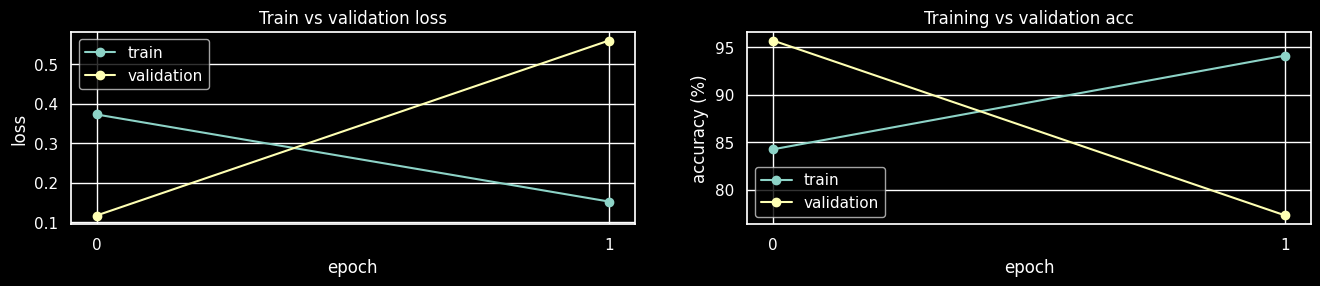

In [17]:
trainer.metrics.plot()


## Save the model 

Save it for later use

In [18]:
model.eval()
model = model.to(memory_format=torch.channels_last)
#model = ipex.optimize(model, dtype=torch.float32)

In [19]:
# quantize model
#quantize=True

from intel_extension_for_pytorch.quantization import prepare, convert
#qconfig = ipex.quantization.default_static_qconfig
qconfig = QConfig(activation=MinMaxObserver.with_args(qscheme=torch.per_tensor_symmetric, dtype=torch.qint8),
                  weight=PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
data = torch.rand(1, 3, 224, 224)
model = prepare(model, qconfig, example_inputs=data, inplace=False)

    

NameError: name 'QConfig' is not defined

In [89]:
for _ in range(200):
    model(data)


In [90]:
model = convert(model)

In [91]:
model_name = "resnet18_3Class_RN_quant.pt"
with torch.no_grad():
    model_scripted = torch.jit.script(model)  # Export to TorchScript
    model_scripted.save(f"models/{model_name}.pt")  # Save


## Load a Saved Model

Use this to load a previously created model to test if we were successfully able to save the model.

In [49]:
model_name = "resnet18_3Class_RN_quantize.pt"
model_read = torch.jit.load(f"models/{model_name}.pt")
model_read.eval()


RecursiveScriptModule(
  original_name=QuantizationDispatchModule
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2

## Infer Function

Used to score and get associated filename for each scored image

In [41]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    paths = []
    for (imgs, _, fpaths) in dataloader:
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
    return images, yhats, paths


## How to use the Infer()

In [42]:
!mkdir data/ThreeClassManualRemove0s/test
!mkdir  data/ThreeClassManualRemove0s/test/unknown
!cp data/DinosaurNationalMonument/20220514/224/*.jpg data/ThreeClassManualRemove0s/test/unknown/

mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test’: File exists
mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test/unknown’: File exists


infered images with labels


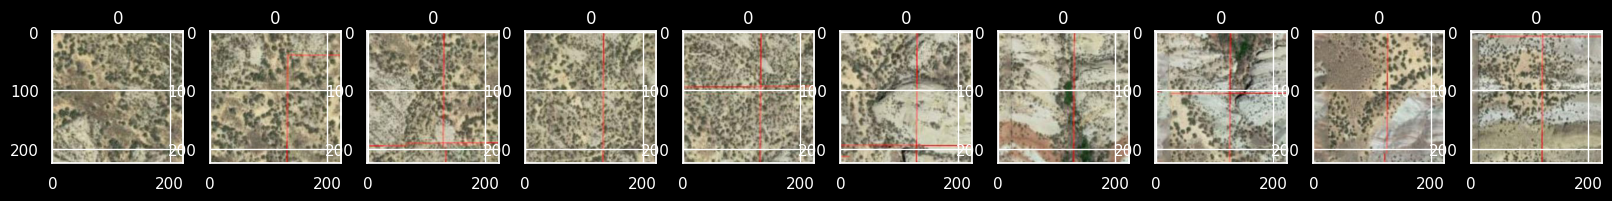

In [43]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
images, yhats, img_paths = infer(
    model_read, data_path="./data/ThreeClassManualRemove0s/test/"
)
infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=100, shuffle=False)
print("infered images with labels")
show_data(infer_dataloader, imagenet_stats, 10, figsize=(20, 8))


If you have any issues or want to contribute, please contact our authors:
Intel oneAPI Solution Architect
- Unnikrishnan Nair, Rahul [rahul.unnikrishnan.nair (at) intel.com]
- Chesebrough, Bob [bob.chesebrough (at) intel.com]

## Lab

1. What will happen to the accuracy curves & training time:
    - if we use ResNet50 as the backbone instead of ResNet18?
    - if another optimizer is used, for Eg. Instead of SGD, if we used Adam?
2. Difference in time taken for training with ipex and without ipex?</br>
    **Note**: To do this experiment, call the `fine_tune` method using `ipx=False`
3. If we don't use the fine-tuning approach and use the same Resnet18 with pretraining turned off (`pretrain=False`), how many epochs do we have to train the model?
4. If we don't `zero` the gradients in the training loop, what effect does it have on training?
5. Can a custom CNN-based classifier be trained to classify our dataset more accurately than the approach we used here?

